In [1]:
from river import stream, tree, metrics
from river.datasets import synth
import random
from river import drift
import river
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.naive_bayes as naive_bayes
import river.drift
from stream_generator import FeatureImportanceChangeGenerator
from feature_selection import run_Boruta, plot_imp_history
import numpy as np
import pandas as pd
from collections import deque
from plots import plot_accuracy_with_drift
from drift_utils import *

In [2]:
generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, random_seed=43, importance_change_interval=1)
adwin = drift.ADWIN()
kswin = drift.KSWIN()

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 0, Accuracy: 0.00%
Drift detected at index 864, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 1000, Accuracy: 87.49%
Drift detected at index 1921, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 2000, Accuracy: 85.24%


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Feature importance changed at epoch 3000.
Epoch 3000, Accuracy: 75.38%
Drift detected at index 3107, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Feature importance changed at epoch 4000.
Epoch 4000, Accuracy: 74.57%
Drift detected at index 4645, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 5000, Accuracy: 75.75%
Drift detected at index 5222, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Feature importance changed at epoch 6000.
Epoch 6000, Accuracy: 77.19%
Drift detected at index 6280, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Feature importance changed at epoch 7000.
Epoch 7000, Accuracy: 77.99%
Drift detected at index 7338, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 8000, Accuracy: 77.32%
Drift detected at index 8299, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 9000, Accuracy: 77.39%
Drift detected at index 9292, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(




           Precision   Recall   F1       Support  
                                                  
       0      76.64%   78.22%   77.42%      4950  
       1      77.70%   76.09%   76.89%      4936  
                                                  
   Macro      77.17%   77.16%   77.16%            
   Micro      77.16%   77.16%   77.16%            
Weighted      77.17%   77.16%   77.16%            

                 77.16% accuracy                  


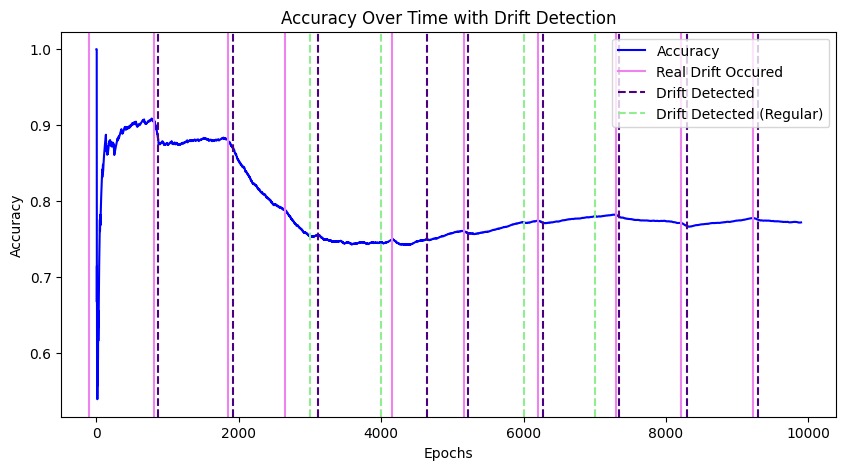

In [3]:
import random

# generator = FeatureImportanceChangeGenerator(20, 5, random_seed=random.randint(0, 300), importance_change_interval=10)
generator = FeatureImportanceChangeGenerator(20, 5, random_seed=160, importance_change_interval=10)

run_drift_detection(generator, adwin)

In [4]:
generator.random_seed

160